In [5]:
# Setup
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Make sure that caffe is on the python path
caffe_root = '/home/azamosavi/Azamosavi/MachineLearning/caffe-master'
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

model_prototxt = 'deploy.prototxt'
pretrained_model = os.path.join(caffe_root,'models/bvlc_alexnet/bvlc_alexnet.caffemodel')

caffe.set_mode_cpu()
net = caffe.Classifier(model_prototxt, pretrained_model,
                       mean=np.load(os.path.join(caffe_root,'python/caffe/imagenet/ilsvrc_2012_mean.npy')).mean(1).mean(1),
                       channel_swap=(2,1,0),
                       raw_scale=255,
                       image_dims=(256, 256))

We start with the image of a cat and desired label as goose. We update input image for `n_iterations` iterations till it maximises class score for goose.

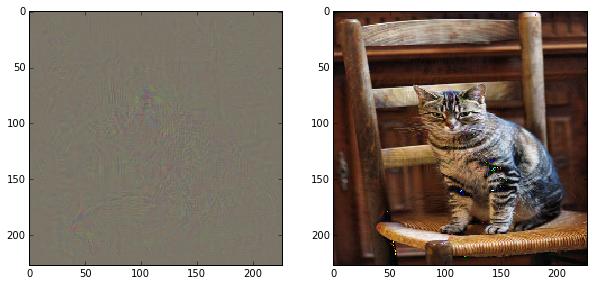

In [6]:
image_file = 'cat_2.jpg'
input_image = caffe.io.load_image(image_file)

n_iterations = 40
desired_label = 99 # goose
label = np.zeros((1,1,1,1000))
label[0,0,0,desired_label] = 1;
step_size = 1000
reg = 0.002

input_image = net.transformer.preprocess('data',input_image)
fooling_image = input_image[:]
zero_image = np.zeros(fooling_image.shape)

for i in range(n_iterations):
    net.blobs['data'].data[...] = fooling_image
    
    # Perform forward pass
    # TODO
    net.forward(data=net.blobs['data'].data[...])
    # END OF YOUR CODE
    
    # Perform backward pass for the desired class
    # TODO
    bw = net.backward(**{net.outputs[0]: label})
    # END OF YOUR CODE
    
    # Compute gradient and incremental update
    # Store update value in di
    # TODO
    
    grad_param = net.blobs['data'].diff
    di = step_size * grad_param
    
    fooling_image += di[0,:,:,:]
    zero_image += di[0,:,:,:]
    
plt.subplot(1,2,1)
plt.imshow(net.transformer.deprocess('data', zero_image))
plt.subplot(1,2,2)
plt.imshow(net.transformer.deprocess('data', fooling_image))

# Save the image
plt.imsave('cat_fooled.jpg',net.transformer.deprocess('data', fooling_image))

Here we check our prediction on the modified image to make sure it is able to 'fool' the ConvNet.

In [7]:
image_file = 'cat_fooled.jpg'
net.blobs['data'].data[...] = net.transformer.preprocess('data',caffe.io.load_image(image_file))
prediction = net.forward()
# load labels
imagenet_labels_filename = os.path.join(caffe_root,'data/ilsvrc12/synset_words.txt')
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
# sort top k predictions from softmax output
top_k = prediction['fc8'][0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n01855672 goose' 'n01847000 drake' 'n01806567 quail'
 'n02018207 American coot, marsh hen, mud hen, water hen, Fulica americana'
 'n02051845 pelican']
